# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from ffnet import MLP, FourierFeatureEmbedding
from ntk import NTK

# Sample Signal Generation

In [ ]:
def random_signal(num_coefs: int
) -> Callable[np.ndarray, np.ndarray]:
    '''Computes a linear combo of pure frequencies'''

    sin_coefs = np.random.standard_normal(num_coefs)
    cos_coefs = np.random.standard_normal(num_coefs)

    rand_func = lambda x : \
                  sum(coef * np.sin(np.pi * x / coef)
                      for coef in sin_coefs) + \
                  sum(coef * np.cos(np.pi * x / coef)
                      for coef in cos_coefs)

    return rand_func

In [ ]:
samp_num_coefs = 12
samp_signal = random_signal(samp_num_coefs)

# Data Initialization

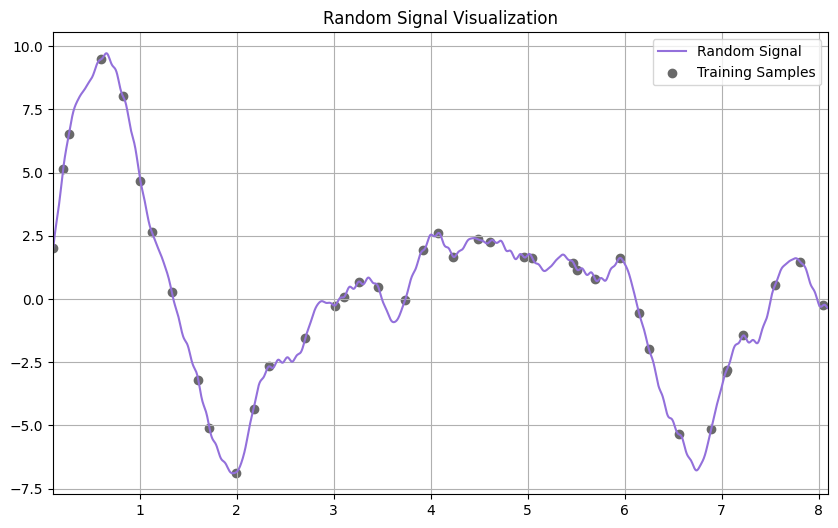

In [ ]:
'''Initializing and visualizing sample data'''
range_min, range_max = 0, 8
range_size = range_max - range_min

num_train_points, num_test_points = 40, 40

base_input = np.linspace(range_min, range_max, num_train_points)

train_input = base_input + np.random.normal(0, 0.1, num_train_points)
test_input = base_input + np.random.normal(0, 0.1, num_train_points)

range_min, range_max = min(train_input), max(test_input)

input_space = np.linspace(range_min, range_max, 2000)
output_space = samp_signal(input_space)

train_output = samp_signal(train_input)
test_output = samp_signal(test_input)

plt.figure(figsize=(10, 6))
plt.grid()

plt.plot(input_space, output_space,
         linewidth=1.5,
         color='mediumpurple',
         label='Random Signal')

plt.scatter(train_input, train_output,
            color='dimgrey',
            label='Training Samples')

plt.xlim(range_min, range_max)
plt.legend()
plt.title('Random Signal Visualization')
plt.show()

# Network Initialization

In [ ]:
'''Global MLP architecture'''

hidden_layers = 4
hidden_width = 32

'''Output tensors'''

space_output_tens = torch.tensor(output_space,
                          dtype=torch.float32).reshape(-1, 1)

train_output_tens = torch.tensor(train_output,
                          dtype=torch.float32).reshape(-1, 1)

test_output_tens = torch.tensor(test_output,
                          dtype=torch.float32).reshape(-1, 1)

In [ ]:
'''Initializing embedding-free data'''

base_space_input_tens = torch.tensor(input_space / range_max,
                          dtype=torch.float32).reshape(-1, 1)

base_train_input_tens = torch.tensor(train_input / range_max,
                               dtype=torch.float32).reshape(-1, 1)

base_test_input_tens = torch.tensor(test_input / range_max,
                               dtype=torch.float32).reshape(-1, 1)

'''Creating datasets and dataloaders'''

base_data_tens = TensorDataset(base_train_input_tens,
                                train_output_tens)

base_loader_tens = DataLoader(base_data_tens, batch_size=1, shuffle=True)

'''Initializing embedding-free network'''

base_mlp = MLP(input_dim=1, output_dim=1,
               hidden_layers=hidden_layers,
               hidden_width=hidden_width)

In [ ]:
'''Initializing RBF and Laplace embeddings'''

num_rand_features = 10
lengths = [5, 1, 0.2]
num_lengths = len(lengths)

rbf_features = [FourierFeatureEmbedding(input_dim=1, num_features=num_rand_features,
                                        kernel='RBF', length_scale=length_scale)
                                        for length_scale in lengths]

lplc_features = [FourierFeatureEmbedding(input_dim=1, num_features=num_rand_features,
                                        kernel='Laplace', length_scale=length_scale)
                                        for length_scale in lengths]

In [ ]:
'''Initializing RBF embedded data'''

rbf_embedded_input_space = [rbf_features[idx].embed(input_space.reshape(-1, 1))
                            for idx in range(num_lengths)]

rbf_embedded_train_input = [rbf_features[idx].embed(train_input.reshape(-1, 1))
                            for idx in range(num_lengths)]

rbf_embedded_test_input = [rbf_features[idx].embed(test_input.reshape(-1, 1))
                            for idx in range(num_lengths)]


rbf_space_input_tens = [torch.tensor(rbf_embedded_input_space[idx],
                          dtype=torch.float32)
                          for idx in range(num_lengths)]

rbf_train_input_tens = [torch.tensor(rbf_embedded_train_input[idx],
                          dtype=torch.float32)
                          for idx in range(num_lengths)]

rbf_test_input_tens = [torch.tensor(rbf_embedded_test_input[idx],
                          dtype=torch.float32)
                          for idx in range(num_lengths)]

'''Creating datasets and dataloaders'''

rbf_data_tens = [TensorDataset(rbf_train_input_tens[idx],
                                train_output_tens)
                                for idx in range(num_lengths)]

rbf_loader_tens = [DataLoader(rbf_data_tens[idx],
                              batch_size=1, shuffle=True)
                              for idx in range(num_lengths)]

'''Initializing RBF networks'''

rbf_mlps = [MLP(input_dim=2 * num_rand_features, output_dim=1,
                hidden_layers=hidden_layers,
                hidden_width=hidden_width)
                for length_scale in lengths]

In [ ]:
'''Initializing Laplace embedded data'''

lplc_embedded_input_space = [lplc_features[idx].embed(input_space.reshape(-1, 1))
                            for idx in range(num_lengths)]

lplc_embedded_train_input = [lplc_features[idx].embed(train_input.reshape(-1, 1))
                            for idx in range(num_lengths)]

lplc_embedded_test_input = [lplc_features[idx].embed(test_input.reshape(-1, 1))
                            for idx in range(num_lengths)]


lplc_space_input_tens = [torch.tensor(lplc_embedded_input_space[idx],
                          dtype=torch.float32)
                          for idx in range(num_lengths)]

lplc_train_input_tens = [torch.tensor(lplc_embedded_train_input[idx],
                          dtype=torch.float32)
                          for idx in range(num_lengths)]

lplc_test_input_tens = [torch.tensor(lplc_embedded_test_input[idx],
                          dtype=torch.float32)
                          for idx in range(num_lengths)]

'''Creating datasets and dataloaders'''

lplc_data_tens = [TensorDataset(lplc_train_input_tens[idx],
                                train_output_tens)
                                for idx in range(num_lengths)]

lplc_loader_tens = [DataLoader(lplc_data_tens[idx],
                              batch_size=1, shuffle=True)
                              for idx in range(num_lengths)]

'''Initializing Laplace networks'''

lplc_mlps = [MLP(input_dim=2 * num_rand_features, output_dim=1,
                hidden_layers=hidden_layers,
                hidden_width=hidden_width)
                for length_scale in lengths]

# Network Training

In [ ]:
'''Initializing tensors'''

space_input_tensors = [base_space_input_tens] + rbf_space_input_tens \
              + lplc_space_input_tens

train_input_tensors = [base_train_input_tens] + rbf_train_input_tens \
              + lplc_train_input_tens

test_input_tensors = [base_test_input_tens] + rbf_test_input_tens \
              + lplc_test_input_tens

train_loaders = [base_loader_tens] + rbf_loader_tens \
              + lplc_loader_tens

mlps = [base_mlp] + rbf_mlps + lplc_mlps

'''Training networks'''

num_iters = 600

num_nets = len(mlps)
train_loss = np.zeros((num_iters, num_nets))
test_loss = np.zeros((num_iters, num_nets))

loss = nn.MSELoss()

for step in range(num_iters):
  for idx in range(num_nets):
    mlps[idx].train(train_loaders[idx], 1)
    temp_train_outs = mlps[idx](train_input_tensors[idx]).detach()
    temp_test_outs = mlps[idx](test_input_tensors[idx]).detach()
    train_loss[step, idx] = loss(temp_train_outs, train_output_tens).item()
    test_loss[step, idx] = loss(temp_test_outs, test_output_tens).item()

# Network Comparison

Text(0.5, 1.0, 'Test loss')

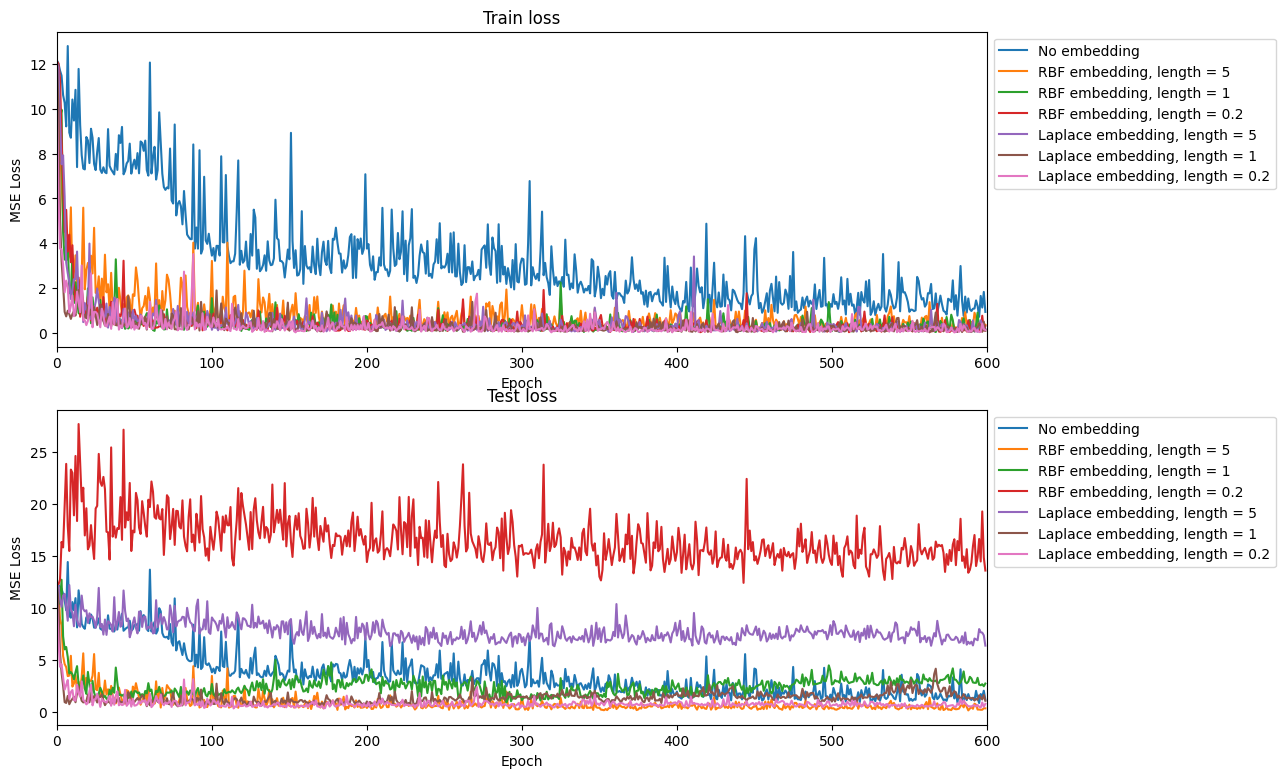

In [ ]:
'''Visualizing train, test loss'''

def get_label(idx: int
) -> str:
    '''Gets a label for train/test loss visualization'''

    if idx == 0:
      return 'No embedding'

    if num_lengths - idx >= 0:
      return 'RBF embedding, length = ' + str(lengths[idx - 1])

    else:
      return 'Laplace embedding, length = ' \
              + str(lengths[idx - num_lengths - 1])

fig, axs = plt.subplots(2, 1, figsize=(12, 9))

for idx in range(num_nets):
  axs[0].plot(train_loss[:, idx], label=get_label(idx), linewidth=1.5)
  axs[1].plot(test_loss[:, idx], label=get_label(idx), linewidth=1.5)

for ctr in range(2):
  axs[ctr].set_xlim(0, num_iters)
  axs[ctr].set_xlabel('Epoch')
  axs[ctr].set_ylabel('MSE Loss')
  axs[ctr].legend(loc='upper left',
                  bbox_to_anchor=(1, 1))

axs[0].set_title('Train loss')
axs[1].set_title('Test loss')

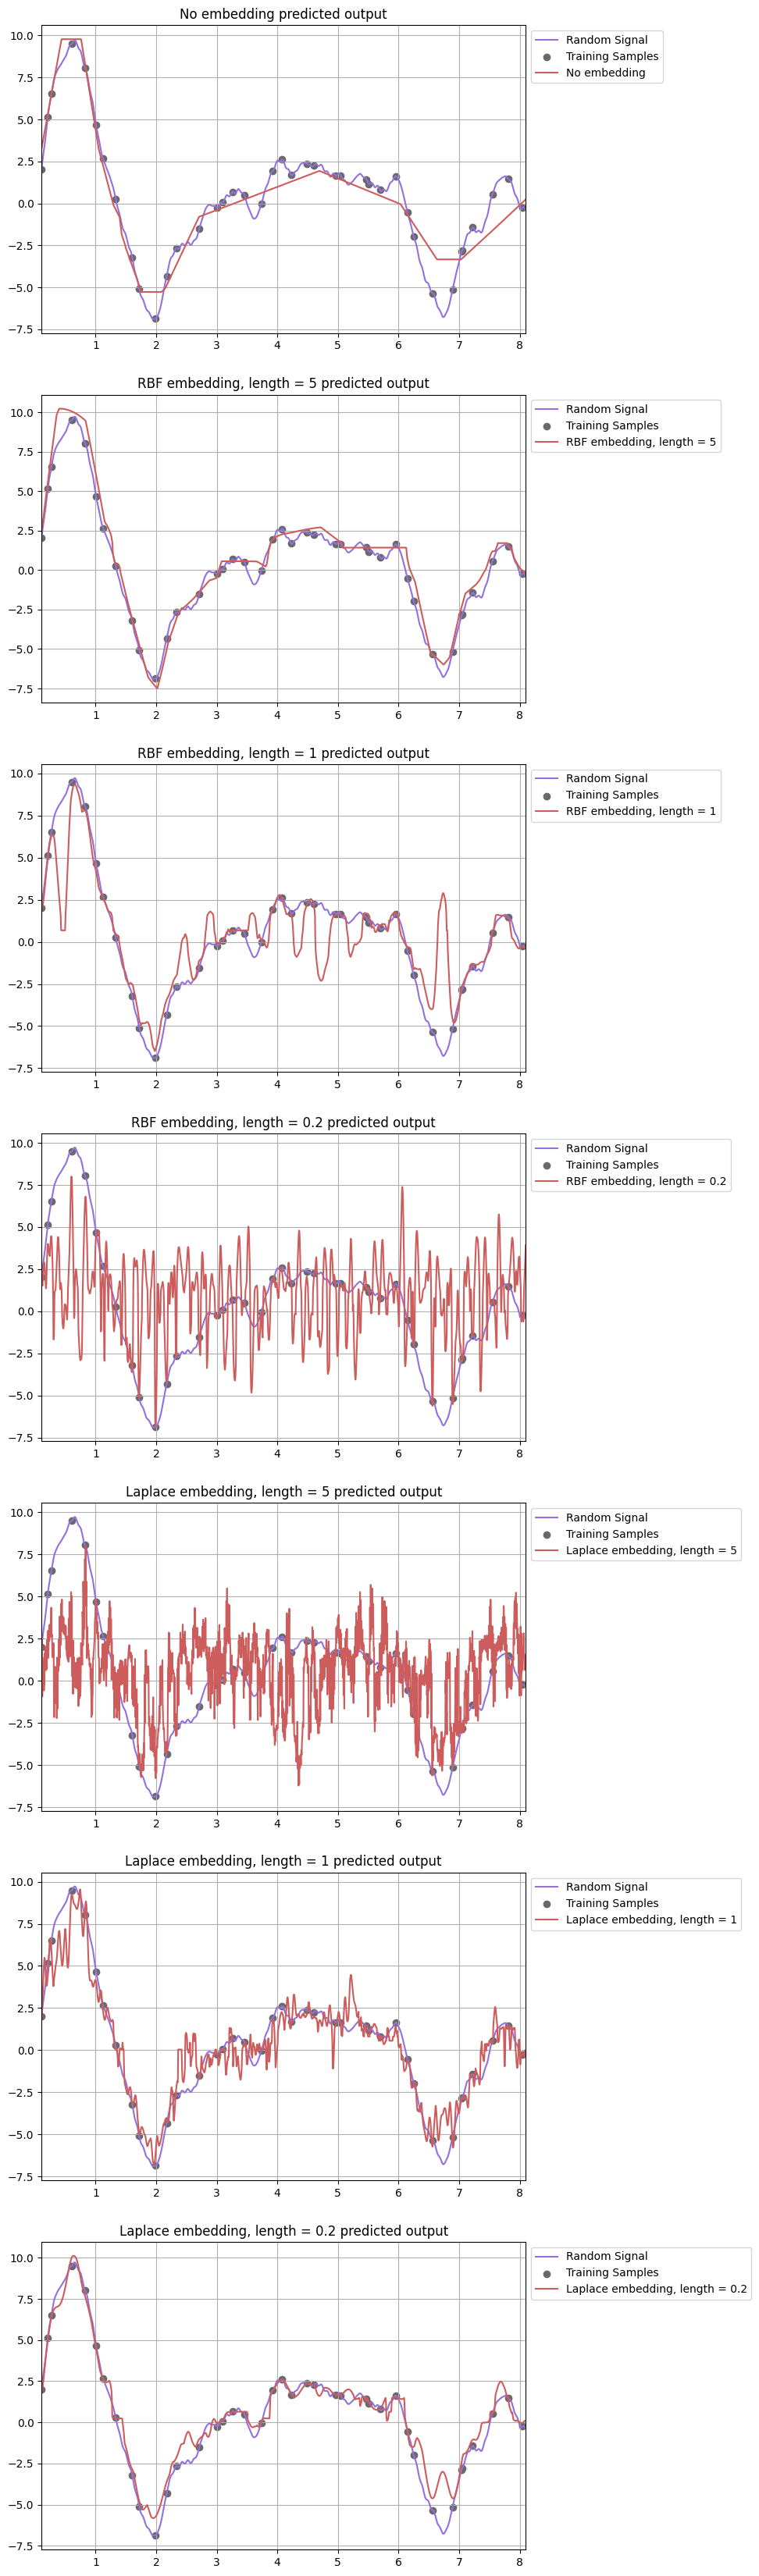

In [ ]:
'''Visualizing network predictions'''

figs, axs = plt.subplots(num_nets, 1, figsize=(8, 6 * num_nets))

for idx in range(num_nets):

  axs[idx].grid()

  axs[idx].plot(input_space, output_space,
         linewidth=1.5,
         color='mediumpurple',
         label='Random Signal')

  axs[idx].scatter(train_input, train_output,
            color='dimgrey',
            label='Training Samples')

  axs[idx].plot(input_space,
                mlps[idx](space_input_tensors[idx]).detach().numpy(),
                color='indianred',
                label=get_label(idx),
                linewidth=1.5)

  axs[idx].set_xlim(range_min, range_max)
  axs[idx].legend(loc='upper left', bbox_to_anchor=(1, 1))
  axs[idx].set_title(get_label(idx) + ' predicted output')

<ipython-input-14-5dfcd5913d93>:6: RuntimeWarning: invalid value encountered in log
  log_spectra = [np.log(ntks[idx].spectrum)


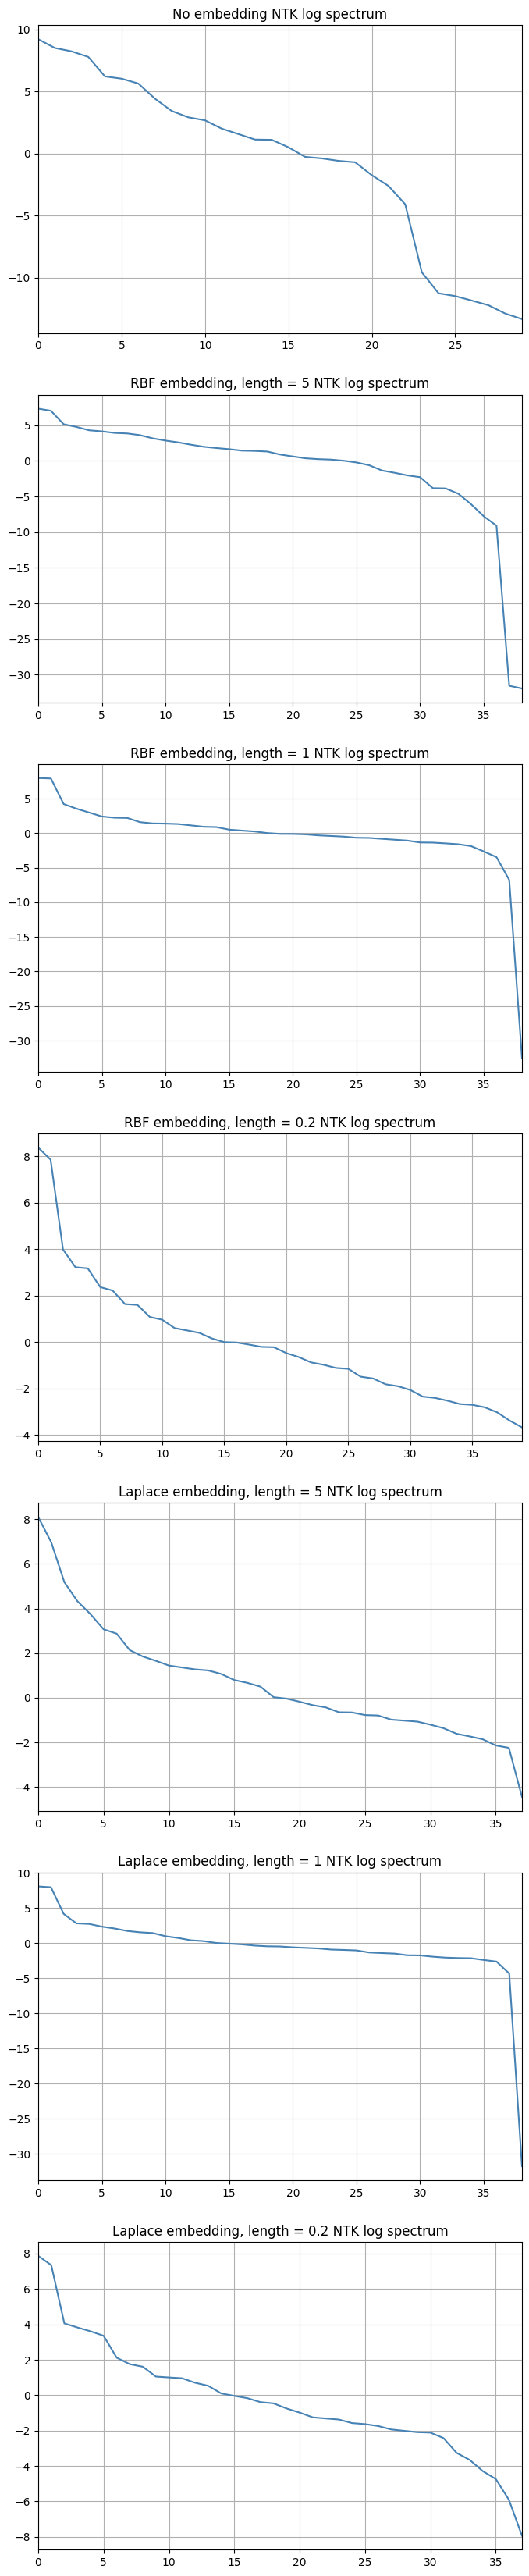

In [ ]:
'''Computing NTK'''

ntks = [NTK(mlps[idx], train_loaders[idx])
        for idx in range(num_nets)]

log_spectra = [np.log(ntks[idx].spectrum)
                for idx in range(num_nets)]

figs, axs = plt.subplots(num_nets, 1, figsize=(8, 6 * num_nets))

for idx in range(num_nets):
  max_spectra = np.sum(~np.isnan(log_spectra[idx]))
  trimmed_spectra = log_spectra[idx][0:max_spectra]

  axs[idx].grid()

  axs[idx].plot(trimmed_spectra,
                linewidth=1.5,
                color='steelblue',
                label=get_label(idx))
  axs[idx].set_xlim(0, max_spectra - 1)
  axs[idx].set_title(get_label(idx) + ' NTK log spectrum')
